# Overview
The kernel here is to show how to build and train a model on the MURA dataset focusing specifically on the problem of classifying finger images. We use Keras to build a basic MobileNet model and then use the ImageDataGenerator to handle augmenting the datasets to create enough diversity to get interesting results. The ```image_cat``` is currently set to _XR_FINGER_ but can be easily tweaked to another category like _XR_SHOULDER_

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 

# Prepare distinct directories of images
Since Keras expects the images to be subfolders of a main directory, so we use sym-links to fake this

In [2]:
def make_vdirs_for_keras(dir_list, catdir_name):
    os.makedirs(catdir_name, exist_ok=True)
    sym_dirs = []
    for c_dir in dir_list:
        n_dir = os.path.join(catdir_name, os.path.basename(c_dir))
        os.symlink(os.path.abspath(c_dir), 
                   n_dir, 
                   target_is_directory=True)
        sym_dirs += [n_dir]

In [3]:
image_cat = 'XR_FINGER'
train_dirs = glob(os.path.join('..', 'input', 'train-{}-*'.format(image_cat)))
valid_dirs = glob(os.path.join('..', 'input', 'valid-{}-*'.format(image_cat)))
test_dir = glob(os.path.join('..', 'input', 'test-{}-*'.format(image_cat)))

keras_train_dirs = make_vdirs_for_keras(train_dirs, 'v_train')
keras_valid_dirs = make_vdirs_for_keras(valid_dirs, 'v_valid')
keras_test_dirs = make_vdirs_for_keras(test_dir, 'v_test')

# Build the data generator

In [4]:
from keras.preprocessing.image import ImageDataGenerator
idg_train_settings = dict(samplewise_center = True,
                         samplewise_std_normalization = True,
                          rotation_range = 5, 
                          width_shift_range = 0.1, 
                         height_shift_range = 0.1,
                         zoom_range = 0.1, 
                         horizontal_flip = True,
                         vertical_flip = True)
idg_train = ImageDataGenerator(**idg_train_settings)

idg_valid_settings = dict(samplewise_center = True,
                         samplewise_std_normalization = True,
                          rotation_range = 0, 
                          width_shift_range = 0., 
                         height_shift_range = 0.,
                         zoom_range = 0.0, 
                         horizontal_flip = False,
                         vertical_flip = False)
idg_valid = ImageDataGenerator(**idg_valid_settings)

Using TensorFlow backend.


In [5]:
train_gen = idg_train.flow_from_directory('v_train', 
                                          follow_links = True, 
                                          target_size=(128, 128), 
                                          color_mode = 'grayscale')

valid_gen = idg_valid.flow_from_directory('v_valid', 
                                          follow_links = True, 
                                          target_size=(128, 128), 
                                          color_mode = 'grayscale')
a, b = next(train_gen)
print(a.shape, a.mean(), a.min(), a.max())
print(b.shape)
print(train_gen.class_indices)
print(valid_gen.class_indices)

Found 5111 images belonging to 2 classes.
Found 461 images belonging to 2 classes.
(32, 128, 128, 1) -4.19095e-09 -3.47769 13.6508
(32, 2)
{'train-XR_FINGER-negative': 0, 'train-XR_FINGER-positive': 1}
{'valid-XR_FINGER-negative': 0, 'valid-XR_FINGER-positive': 1}


# Verify Images
Here we verify the images are loading correctly, are readable and deliver reasonably understandable results

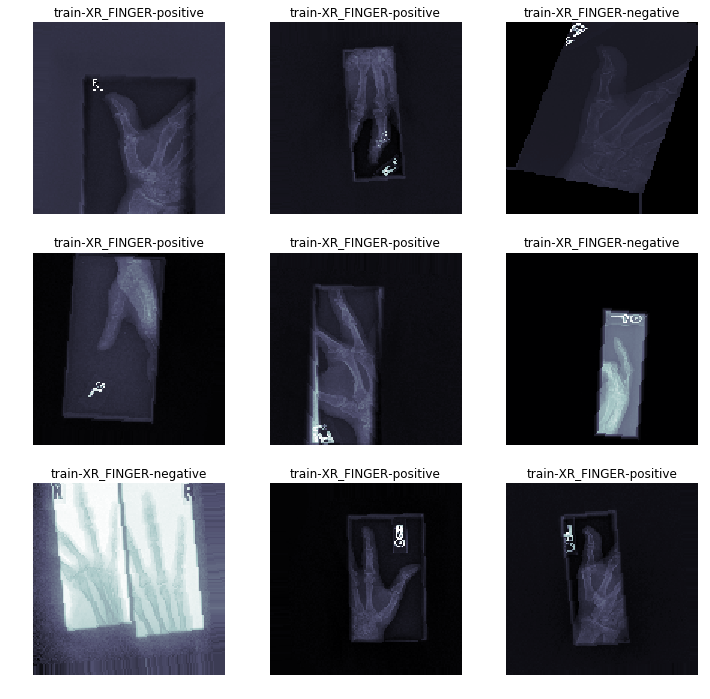

In [6]:
tg_class = {v:k for k,v in train_gen.class_indices.items()}
fig, m_axs = plt.subplots(3, 3, figsize = (12, 12))
for c_ax, c_img, c_lab in zip(m_axs.flatten(), a, b):
    c_ax.imshow(c_img[:,:,0], cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title(tg_class[np.argmax(c_lab)])

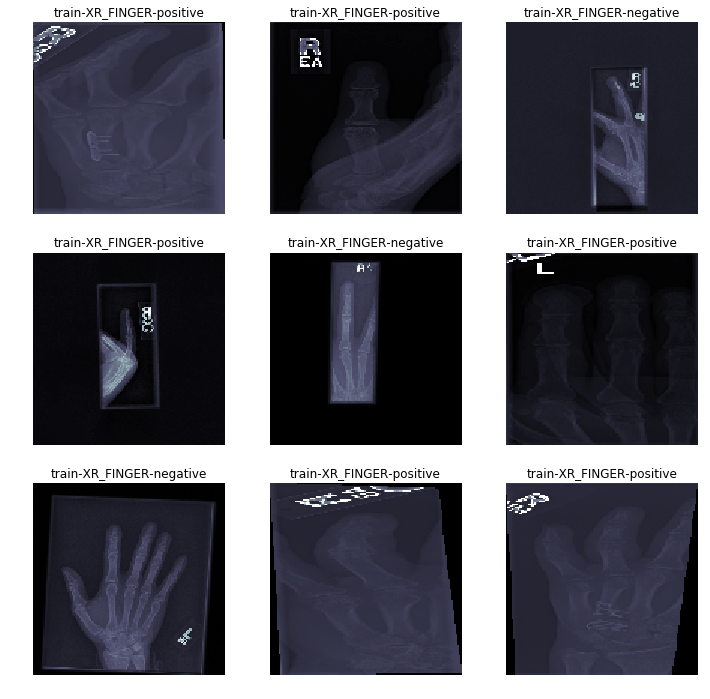

In [7]:
a, b = next(valid_gen)
vg_class = {v:k for k,v in valid_gen.class_indices.items()}
fig, m_axs = plt.subplots(3, 3, figsize = (12, 12))
for c_ax, c_img, c_lab in zip(m_axs.flatten(), a, b):
    c_ax.imshow(c_img[:,:,0], cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title(tg_class[np.argmax(c_lab)])

# Build a Model
We use an untrained MobileNet to process the images

In [8]:
from keras.applications.mobilenet import MobileNet
s_net = MobileNet(classes=b.shape[1], weights = None, input_shape=a.shape[1:])
s_net.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['acc'])

In [9]:
print('Layers: {}, parameters: {}'.format(len(s_net.layers), s_net.count_params()))

Layers: 88, parameters: 3230338


In [10]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
file_path="weights.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', 
                             verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_acc", mode="max", patience=3)
callbacks_list = [checkpoint, early] #early

In [11]:
s_net.fit_generator(train_gen, 
                    steps_per_epoch = 30, 
                    validation_data = valid_gen,
                    validation_steps = 10,
                    epochs=12,
                   callbacks = callbacks_list)

Epoch 1/12
29/30 [============================>.] - ETA: 3s - loss: 0.7451 - acc: 0.6228
Epoch 00001: val_loss improved from inf to 0.88775, saving model to weights.best.hdf5
30/30 [==============================] - 121s 4s/step - loss: 0.7429 - acc: 0.6229 - val_loss: 0.8877 - val_acc: 0.6031
Epoch 2/12
29/30 [============================>.] - ETA: 3s - loss: 0.7415 - acc: 0.5808
Epoch 00002: val_loss did not improve
30/30 [==============================] - 117s 4s/step - loss: 0.7343 - acc: 0.5844 - val_loss: 2.1823 - val_acc: 0.4651
Epoch 3/12
29/30 [============================>.] - ETA: 3s - loss: 0.7284 - acc: 0.5932
Epoch 00003: val_loss improved from 0.88775 to 0.74894, saving model to weights.best.hdf5
30/30 [==============================] - 119s 4s/step - loss: 0.7283 - acc: 0.5932 - val_loss: 0.7489 - val_acc: 0.5947
Epoch 4/12
29/30 [============================>.] - ETA: 3s - loss: 0.6530 - acc: 0.6573
Epoch 00004: val_loss did not improve
30/30 [=========================

# Run the validation data
Here we run the validation data with minimal augmentation to see how well it performs and calculate a few stats

In [12]:
s_net.load_weights(file_path) # load the best model

In [13]:
from tqdm import tqdm
valid_flow = idg_valid.flow_from_directory('v_valid', 
                                          follow_links = True, 
                                          target_size=(128, 128), 
                                          color_mode = 'grayscale',
                                          shuffle = False)
out_x, out_y, pred_y = [], [], []
for _, (tX, tY) in zip(tqdm(range(len(valid_flow.filenames)//32)), valid_flow):
    out_x += [tX]
    out_y += [tY]
    pred_y += [s_net.predict(tX)]

  0%|          | 0/14 [00:00<?, ?it/s]

Found 461 images belonging to 2 classes.


100%|██████████| 14/14 [00:20<00:00,  1.49s/it]


In [14]:
# concatenate to single array
out_cat_y = np.argmax(np.concatenate(out_y, 0), -1)
pred_cat_y = np.argmax(np.concatenate(pred_y, 0), -1)
pred_conf_y = np.concatenate(pred_y, 0)[:,1]

             precision    recall  f1-score   support

          0       0.73      0.31      0.44       214
          1       0.59      0.89      0.71       234

avg / total       0.65      0.62      0.58       448



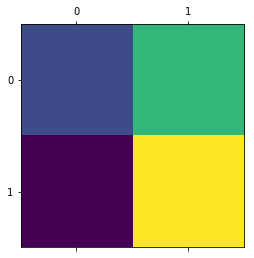

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(out_cat_y, pred_cat_y))
plt.matshow(confusion_matrix(out_cat_y, pred_cat_y))

# Make an ROC
Here we create a simple ROC curve to evaluate the model

Text(0,0.5,'True Positive Rate')

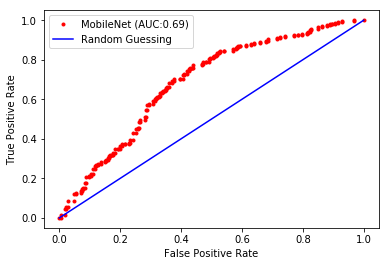

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(out_cat_y, pred_conf_y)
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r.', label = 'MobileNet (AUC:%2.2f)' % roc_auc_score(out_cat_y, pred_conf_y))
ax1.plot(fpr, fpr, 'b-', label = 'Random Guessing')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')

In [17]:
# clean up the virtual directories
import shutil
for c_dir in glob('v_*'):
    shutil.rmtree(c_dir)